# Prepare TFRecord Dataset

Taking `samples/example/*.jpg` with 20 images for example, to explore the following points:

- create image path dataset and split train/test sets
- write image data/labels to TFRecord files
- load dataset from TFRecord file

Then, save this process as `prepare_dataset.py` for further reuse.

In [1]:
import tensorflow as tf

## 1. Create Image Path Dataset

split train / test dataset

In [6]:
def split_train_test(file_pattern, test_rate=0.1, buffer_size=10000):
    # by default, tf.data.Dataset.list_files always shuffles order during iteration
    # so set it false explicitly
    dataset = tf.data.Dataset.list_files(file_pattern, shuffle=False)
    
    # shuffle first and stop shuffling during each iteration
    # buffer_size is reccommanded to be larger than dataset size
    dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=False)
    
    # define split interval
    sep = int(1.0/test_rate)
    is_test = lambda x, y: x % sep == 0
    is_train = lambda x, y: not is_test(x, y)
    recover = lambda x,y: y
    
    # split train/test set, and reset buffle mode: 
    # keep shuffle order different during iteration
    test_dataset = dataset.enumerate(start=1).filter(is_test).map(recover)
    train_dataset = dataset.enumerate(start=1).filter(is_train).map(recover)
    
    return train_dataset, test_dataset

In [10]:
train_set, test_set = split_train_test('samples/example/*.jpg', 0.15)
list(test_set.as_numpy_iterator())

[b'samples\\example\\aaen.jpg',
 b'samples\\example\\aaet.jpg',
 b'samples\\example\\aafd.jpg']

## 2. Write Image to TFRecord File

In [11]:
# Create a dictionary with features: image raw data, label
def image_example(path):
    """path: image path, e.g. b'test\\lcrh.jpg'"""
    # get image raw data and labels
    image_string = open(path, 'rb').read()
    image_labels = tf.strings.substr(path, -8, 4)
    
    # preparation for tf.train.Example
    feature = {
      'labels': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_labels.numpy()])),
      'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string]))
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Write raw image data to `images.tfrecords`
def write_dataset_to_tfrecord(record_file, dataset):
    '''dataset: path dataset'''
    with tf.io.TFRecordWriter(record_file) as writer:
        for path in dataset.as_numpy_iterator():
            tf_example = image_example(path)
            writer.write(tf_example.SerializeToString())

In [13]:
# example: 
# store image features in the tf.Example message, and show the content
path = next(train_set.take(1).as_numpy_iterator())
for line in str(image_example(path)).split('\n')[:5]:
    print(line)
print('...')

features {
  feature {
    key: "image_raw"
    value {
      bytes_list {
...


In [14]:
# Write the raw image files to `images.tfrecords`
train_record_file = 'dataset/example_train.tfrecords'
test_record_file = 'dataset/example_test.tfrecords'
write_dataset_to_tfrecord(train_record_file, train_set)
write_dataset_to_tfrecord(test_record_file, test_set)

## 3. Create Dataset from TFRecord File

In [18]:
def _decode_image(image, resize=(60, 120), grayscale=False):
    '''preprocess image with given raw data
        - image: image raw data
    '''
    image = tf.image.decode_jpeg(image, channels=3)
    
    # convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, resize)
    
    # RGB to grayscale -> channels=1
    if grayscale:
        image = tf.image.rgb_to_grayscale(image) # shape=(h, w, 1)

    return image # (h, w, c)

# get labels
def _decode_labels(labels, prefix):
    ''' this function is used within dataset.map(), 
        where eager execution is disables by default:
            check tf.executing_eagerly() returns False.
        So any Tensor.numpy() is not allowed in this function.
    '''
    dict_labels = {}
    for i in range(4):
        c = tf.strings.substr(labels, i, 1) # labels example: b'abcd'
        label = tf.strings.unicode_decode(c, input_encoding='utf-8') - ord('a')
        dict_labels[f'{prefix}_{i}'] = label
    return dict_labels

def _parse_image_function(example_proto, image_size, label_prefix):
    # Parse the input tf.Example proto using the dictionary describing the features.
    image_feature_description = {
        'labels'   : tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string)
    }
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    
    # decode image array and labels
    image_data = _decode_image(image_features['image_raw'], image_size)
    dict_labels = _decode_labels(image_features['labels'], label_prefix)
    
    return image_data, dict_labels

# create image/labels dataset from TFRecord file
def create_dataset_from_tfrecord(record_file, 
    batch_size=32, 
    image_size=(60, 120), 
    label_prefix='labels',
    buffer_size=10000):
    '''create image/labels dataset from TFRecord file'''          
    return tf.data.TFRecordDataset(record_file).map(
        lambda example_proto: _parse_image_function(example_proto, image_size, label_prefix),
        num_parallel_calls=tf.data.experimental.AUTOTUNE # -1 any available CPUs
    ).shuffle(buffer_size).batch(batch_size)

In [19]:
# create (image, label) dataset from TFRecord file
train_ds = create_dataset_from_tfrecord(train_record_file, batch_size=32, image_size=(60, 120), label_prefix='A')
test_ds = create_dataset_from_tfrecord(test_record_file, batch_size=32, image_size=(60, 120), label_prefix='A')

train_ds.element_spec

(TensorSpec(shape=(None, 60, 120, 3), dtype=tf.float32, name=None),
 {'A_0': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'A_1': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'A_2': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
  'A_3': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)})

## 4. Show Images in First Batch

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# get images in first batch
batch_images, batch_labels = next(train_ds.take(1).as_numpy_iterator())

# check shape
print(batch_images.shape) # (batch_size, height, width, channels)

for k,v in batch_labels.items(): # batch_labels is a dict with batch size for each value
    print(k, ' -> ', v.shape) # batch_size

(17, 60, 120, 3)
A_0  ->  (17, 1)
A_1  ->  (17, 1)
A_2  ->  (17, 1)
A_3  ->  (17, 1)


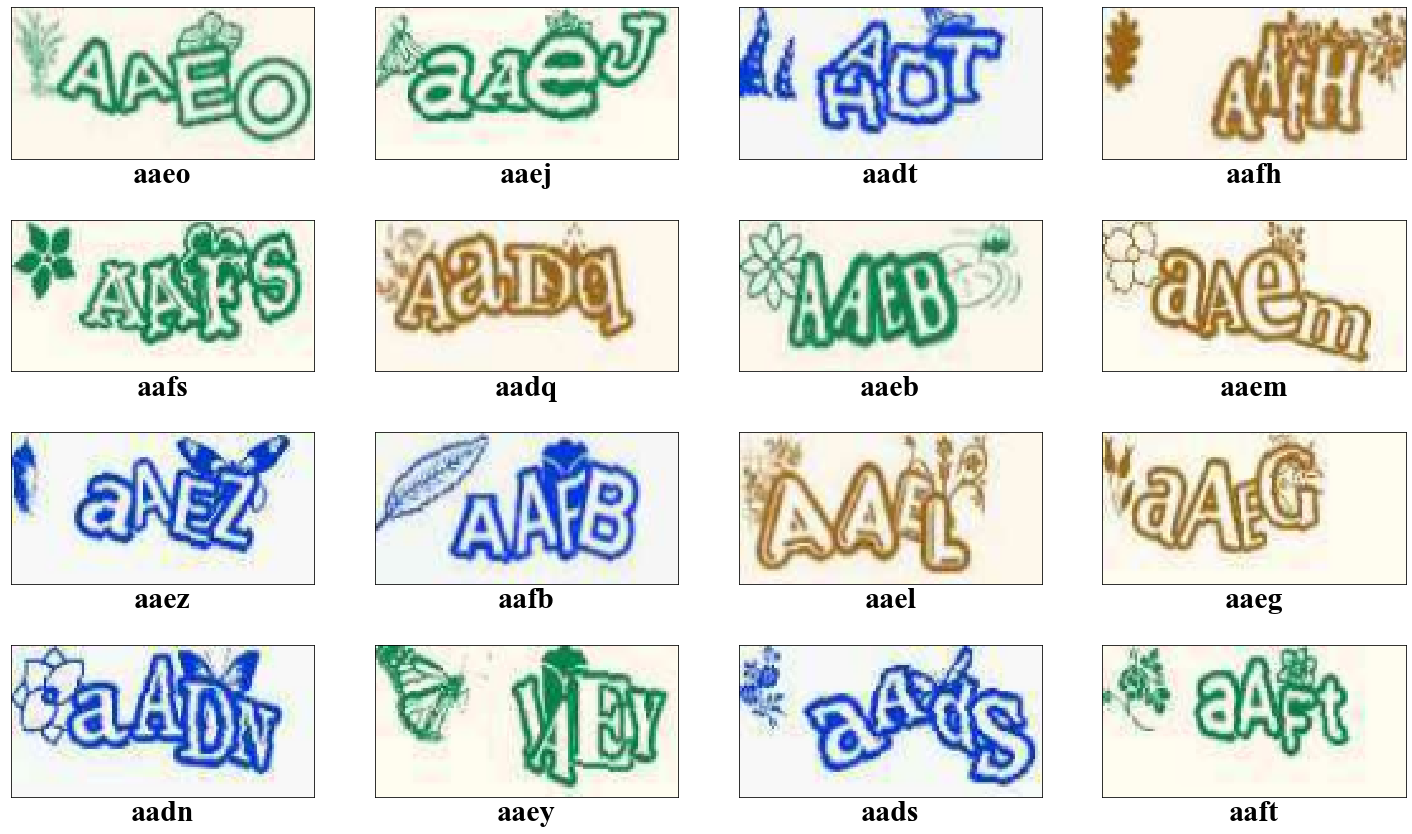

In [23]:
plt.figure(figsize=(25,15)) # width, height
for i,(image,*labels) in enumerate(zip(batch_images, *batch_labels.values()), start=1):
    if i > 16:  break
    plt.subplot(4, 4, i)
    
    # imshow get image shape: either (h, w, c=3) for RGB images
    # or (h, w) for gray image
    if image.shape[-1] == 1:
        image = tf.reshape(image, shape=(60, 120))

    plt.imshow(image, cmap=plt.cm.binary)    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(''.join([chr(ord('a') + c) for c in labels]), 
               fontdict={'family': 'Times New Roman', 'size' : 30})
plt.show()